# **IMPORTADO DE MÓDULOS**

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.optimizers import Adam

2024-04-30 12:24:02.824184: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 12:24:02.849169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 12:24:03.211491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [4]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

# **INTERPOLACION**

In [5]:
start = 50
stop = 80
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28[:,start:stop,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28[:,start:stop,:],  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55[:,start:stop,:],  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82[:,start:stop,:],  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 30
Time step: 0.20
New number of time points: 240
New time step: 0.0250


In [45]:
Ntrain_V55 = int(0.7*new_V55.shape[0])
Ntrain_V28 = int(0.6*new_V28.shape[0])
Ntrain_V82 = int(0.7*new_V82.shape[0])
train_data = np.concatenate((new_V55[0:Ntrain_V55,:,:],new_V28[0:Ntrain_V28,:,:],new_V82[0:Ntrain_V82,:,:]),axis = 0).swapaxes(1,2)
validation_data = np.concatenate((new_V55[Ntrain_V55:,:,:],new_V28[Ntrain_V28:,:,:],new_V82[Ntrain_V82:,:,:]),axis = 0).swapaxes(1,2)
REF = np.zeros(train_data.shape[0])
REF[0:Ntrain_V55] = 0.0
REF[Ntrain_V55:Ntrain_V55 + Ntrain_V28] = -0.2
REF[Ntrain_V55 + Ntrain_V28:] = 0.2

# **NEURAL NETWORK**

In [56]:
def model_definition(N_points):

  input_shape = (2,N_points,1)


  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=(2, 2), activation='relu', padding = 'same', input_shape=input_shape)) #ouput_dim = (2, N_points, 16)
  model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding = 'same')) #ouput_dim = (2, N_points, 32)
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(4, activation='relu'))
  model.add(Dense(1, activation='linear'))
  return model

In [57]:
model = model_definition(Nt_new)
model.compile(optimizer='AdamW',loss='MSE')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 2, 240, 16)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 240, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 120, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       122,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,105 (488.69 KB)

 Trainable params: 125,105 (488.69 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
history = model.fit(train_data, REF, epochs=750, batch_size=64)

Epoch 1/750


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0258
Epoch 2/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0195 
Epoch 3/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127 
Epoch 4/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 
Epoch 5/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0045 
Epoch 6/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 
Epoch 7/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 
Epoch 8/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 
Epoch 9/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 
Epoch 10/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 
Epoch 11/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 
Epoch 12/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 
Epoch 13/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 
Epoch 14/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 
Epoch 15/750
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 
Epoch 16/750
8/8 ━━━━━━━━━━━━━━

In [59]:
TOF = model.predict(validation_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step



V82: CENTROID(ns) = 0.193  FWHM(ns) = 0.023  std(ns) = 0.010
V55: CENTROID(ns) = -0.003  FWHM(ns) = 0.095  std(ns) = 0.040
V28: CENTROID(ns) = -0.215  FWHM(ns) = 0.037  std(ns) = 0.016


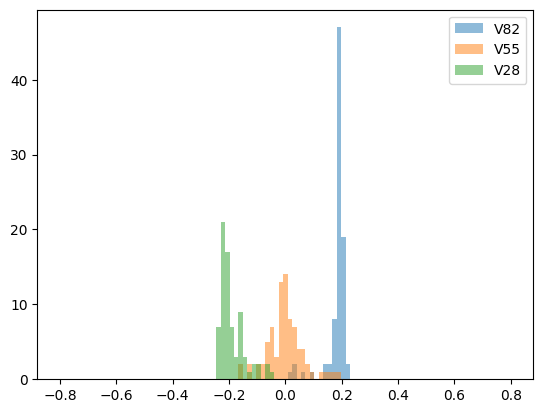

In [60]:
Nval_V28 = new_V28[Ntrain_V28:,:,:].shape[0]
Nval_V55 = new_V55[Ntrain_V55:,:,:].shape[0]
Nval_V82 = new_V82[Ntrain_V82:,:,:].shape[0]
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=101
histogN_V82, binsN, patchesN  = plt.hist(TOF[Nval_V55 + Nval_V28:] - np.mean(TOF[0:Nval_V55]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOF[0:Nval_V55] - np.mean(TOF[0:Nval_V55]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOF[Nval_V55: Nval_V55 + Nval_V28] - np.mean(TOF[0:Nval_V55]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

# **DETECTOR 0**

In [13]:
train_data = np.concatenate((new_V55,new_V28,new_V82),axis = 0)

In [14]:
Ncasos = train_data.shape[0]
INPUT_dec0 = np.zeros_like(train_data)
REF_dec0 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-3, size=N0)
  noise00 = np.random.normal(scale=0.01, size=INPUT_dec0.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT_dec0[i,:,0]=np.roll(train_data[i,:,0],N0)
  INPUT_dec0[i,:,0] = INPUT_dec0[i,:,0] + smoothed_noise
  INPUT_dec0[i,0:N0,0] = noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-3, size=N1)
  noise11 = np.random.normal(scale=0.01, size=INPUT_dec0.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT_dec0[i,:,1]=np.roll(train_data[i,:,0],N1)
  INPUT_dec0[i,:,1] = INPUT_dec0[i,:,1] + smoothed_noise
  INPUT_dec0[i,0:N1,1] = noise1

  REF_dec0[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)



trainX_dec0 = INPUT_dec0[:,:,:].swapaxes(1,2)
REF_train_dec0 = REF_dec0[:]

# **DETECTOR 1**

In [15]:
Ncasos = train_data.shape[0]
INPUT_dec1 = np.zeros_like(train_data)
REF_dec1 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-3, size=N0)
  noise00 = np.random.normal(scale=0.01, size=INPUT_dec1.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT_dec1[i,:,0]=np.roll(train_data[i,:,1],N0)
  INPUT_dec1[i,:,0] = INPUT_dec1[i,:,0] + smoothed_noise
  INPUT_dec1[i,0:N0,0] = noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-3, size=N1)
  noise11 = np.random.normal(scale=0.01, size=INPUT_dec1.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT_dec1[i,:,1]=np.roll(train_data[i,:,1],N1)
  INPUT_dec1[i,:,1] = INPUT_dec1[i,:,1] + smoothed_noise
  INPUT_dec1[i,0:N1,1] = noise1

  REF_dec1[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)



trainX_dec1 = INPUT_dec1[:,:,:].swapaxes(1,2)
REF_train_dec1 = REF_dec1[:]

# **FULL TOF**

In [48]:
REFERENCE_PULSE_dec0 = np.tile(new_V55[0,:,0], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V55[0,:,1], (new_V82.shape[0],2,1)).swapaxes(1,2)

In [49]:
test_dec0_V28 = np.stack((REFERENCE_PULSE_dec0[:new_V28.shape[0],:,0],new_V28[:,:,0]),axis=2).swapaxes(1,2)
test_dec1_V28 = np.stack((REFERENCE_PULSE_dec1[:new_V28.shape[0],:,0],new_V28[:,:,1]),axis=2).swapaxes(1,2)
test_dec0_V55 = np.stack((REFERENCE_PULSE_dec0[:new_V55.shape[0],:,0],new_V55[:,:,0]),axis=2).swapaxes(1,2)
test_dec1_V55 = np.stack((REFERENCE_PULSE_dec1[:new_V55.shape[0],:,0],new_V55[:,:,1]),axis=2).swapaxes(1,2)
test_dec0_V82 = np.stack((REFERENCE_PULSE_dec0[:new_V82.shape[0],:,0],new_V82[:,:,0]),axis=2).swapaxes(1,2)
test_dec1_V82 = np.stack((REFERENCE_PULSE_dec1[:new_V82.shape[0],:,0],new_V82[:,:,1]),axis=2).swapaxes(1,2)

In [ ]:
epochs = 750
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):
  #tf.random.set_seed(seed_value)
  
  model_dec0 = model_definition(Nt_new)
  model_dec1 = model_definition(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=5e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=5e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(trainX_dec0, REF_train_dec0, epochs=1,verbose=0)
     history_dec1 = model_dec1.fit(trainX_dec1, REF_train_dec1, epochs=1,verbose=0)
     
     loss_dec0.append(history_dec0.history['loss'])
     loss_dec1.append(history_dec1.history['loss'])

     
     TOFN_dec0_REF_V82 = model_dec0.predict(test_dec0_V82)
     TOFN_dec1_REF_V82 = model_dec1.predict(test_dec1_V82)
     TOFN_dec0_REF_V55 = model_dec0.predict(test_dec0_V55)
     TOFN_dec1_REF_V55 = model_dec1.predict(test_dec1_V55)
     TOFN_dec0_REF_V28 = model_dec0.predict(test_dec0_V28)
     TOFN_dec1_REF_V28 = model_dec1.predict(test_dec1_V28)


     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = -1*np.mean(TOFN_V28) + np.mean(TOFN_V55)
     centroid_V82 = -1*np.mean(TOFN_V82) + np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

(array([0]), array([728])) 0.07455600812936135


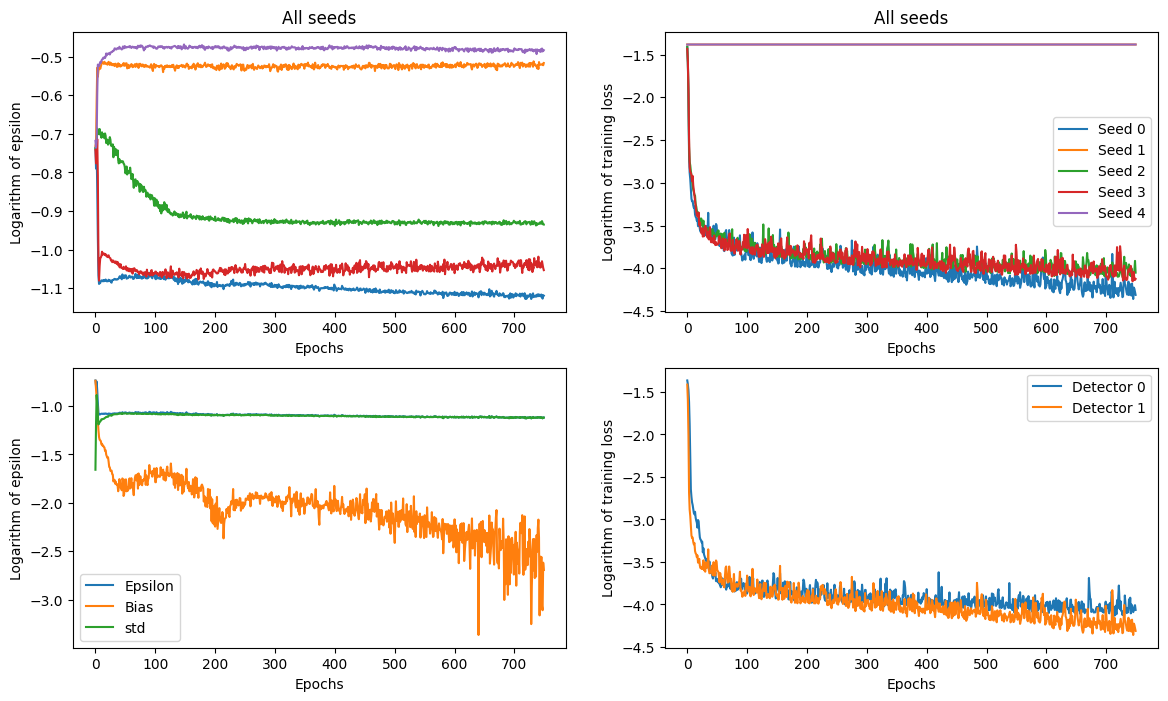

In [52]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 0
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  #plt.plot(np.log10(std[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.193  FWHM(ns) = 0.191  std(ns) = 0.081
V55: CENTROID(ns) = 0.005  FWHM(ns) = 0.179  std(ns) = 0.076
V28: CENTROID(ns) = -0.195  FWHM(ns) = 0.165  std(ns) = 0.070


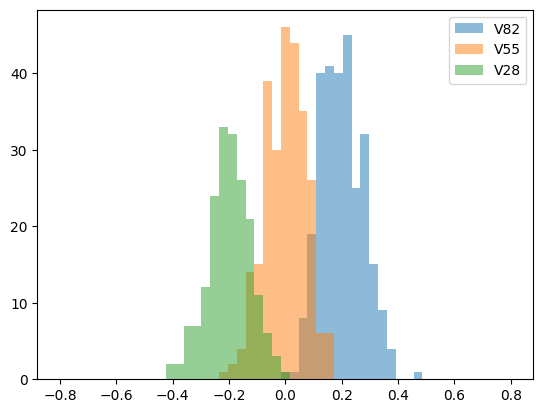

In [53]:
epoch = 728
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_V82_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(TOFN_V55_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(TOFN_V28_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

# **ENSEMBLE MODEL**

In [54]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)


Weighted mean:
V82: CENTROID(ns) = 0.192  FWHM(ns) = 0.188  std(ns) = 0.080
V55: CENTROID(ns) = 0.005  FWHM(ns) = 0.176  std(ns) = 0.075
V28: CENTROID(ns) = -0.195  FWHM(ns) = 0.164  std(ns) = 0.070


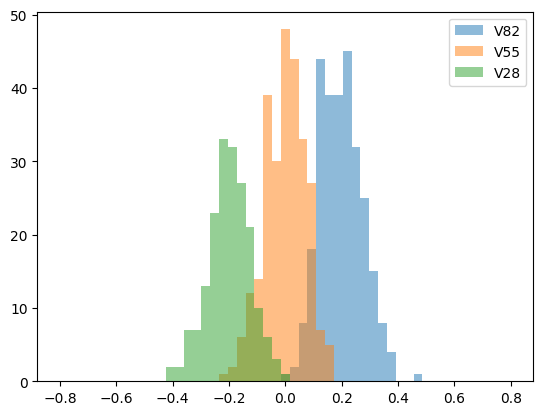

In [55]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(weighted_mean_V82) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(weighted_mean_V55) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(weighted_mean_V28) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28

print('')
print('Weighted mean:')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))